In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import xarray
import dask

import psutil
import time

In [2]:
dask.config.set(scheduler="processes")

# Performace analysis

This notebook compares the performance of remote data access versus next to data data access.

In [3]:
df = pd.read_csv("../../inventory.csv")
subset = df.query('variable == "t" & project == "CMIP6" & frequency == "mon" & experiment == "ssp585"')
subset

,location,type,variable,project,experiment,frequency
87,https://hub.climate4r.ifca.es/thredds/dodsC/ip...,opendap,t,CMIP6,ssp585,mon
950,/home/jovyan/shared/data/IPCC-WGI_AR6_Interact...,netcdf,t,CMIP6,ssp585,mon


In [4]:
list(subset["location"])

['https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/t_CMIP6_ssp585_mon_201501-210012.nc',
 '/home/jovyan/shared/data/IPCC-WGI_AR6_Interactive_Atlas_Dataset/CMIP6/ssp585/t_CMIP6_ssp585_mon_201501-210012.nc']

## Measurements

First we define the parameters of the performance experiment. We test different number of workers and we perform several runs of each number of workers.

In [5]:
nworkers = [1, 2, 4, 8]
runs = 5
results = []

def measure(op, name, nworkers, run):
    start_net = psutil.net_io_counters()
    start_time = time.time()

    op.compute(num_workers=nworkers)

    end_time = time.time()
    end_net = psutil.net_io_counters()

    result = {
        "name": name,
        "run": run,
        "time": end_time-start_time,
        "bytes_recv": end_net.bytes_recv-start_net.bytes_recv,
        "bytes_sent": end_net.bytes_sent-start_net.bytes_sent,
        "packets_recv": end_net.packets_recv-start_net.packets_recv,
        "packets_sent": end_net.packets_sent-start_net.packets_sent,
        "errin": end_net.errin-start_net.errin,
        "errout": end_net.errout-start_net.errout,
        "dropin": end_net.dropin-start_net.dropin,
        "dropout": end_net.dropout-start_net.dropout,
        "workers": nworkers
    }

    return result

### Local data access (hub)

In [6]:
location = subset[subset["type"] == "netcdf"]["location"].iloc[0]
location

'/home/jovyan/shared/data/IPCC-WGI_AR6_Interactive_Atlas_Dataset/CMIP6/ssp585/t_CMIP6_ssp585_mon_201501-210012.nc'

In [7]:
for w in nworkers:
    for r in range(runs):
        ds = xarray.open_dataset(location).chunk(member=1, time=200)
        op = ds["t"].mean(["lat", "lon", "member"])
        results.append(measure(op, "local", w, r))

### OPeNDAP without compression (hub)

In [8]:
location = subset[subset["type"] == "opendap"]["location"].iloc[0]
location

'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/t_CMIP6_ssp585_mon_201501-210012.nc'

In [9]:
!sed -i 's|DEFLATE=1|DEFLATE=0|' ~/.dodsrc

In [10]:
for w in nworkers:
    for r in range(runs):
        ds = xarray.open_dataset(location).chunk(member=1, time=200)
        op = ds["t"].mean(["lat", "lon", "member"])
        results.append(measure(op, "opendap-hub-uncompressed", w, r))

### OPeNDAP with compression (hub)

In [11]:
location = subset[subset["type"] == "opendap"]["location"].iloc[0]
location

'https://hub.climate4r.ifca.es/thredds/dodsC/ipcc/ar6/atlas/ia-monthly/CMIP6/ssp585/t_CMIP6_ssp585_mon_201501-210012.nc'

In [12]:
!sed -i 's|DEFLATE=0|DEFLATE=1|' ~/.dodsrc

In [13]:
for w in nworkers:
    for r in range(runs):
        ds = xarray.open_dataset(location).chunk(member=1, time=200)
        op = ds["t"].mean(["lat", "lon", "member"])
        results.append(measure(op, "opendap-hub-compressed", w, r))

## Analysis of results

In [14]:
df = pd.DataFrame.from_records(results)
df.to_csv("hub.csv", index=False)
df

,name,run,time,bytes_recv,bytes_sent,packets_recv,packets_sent,errin,errout,dropin,dropout,workers
0,local,0,87.556871,118026,373764,446,460,0,0,0,0,1
1,local,1,87.525362,64173,253501,345,356,0,0,0,0,1
2,local,2,87.125905,32754,81943,224,238,0,0,0,0,1
3,local,3,87.045820,18712,19642,175,190,0,0,0,0,1
4,local,4,87.534261,18640,19508,174,188,0,0,0,0,1
5,local,0,77.576699,17195,18076,160,174,0,0,0,0,2
6,local,1,78.330945,17460,18138,163,174,0,0,0,0,2
7,local,2,77.945281,17532,18272,164,176,0,0,0,0,2
8,local,3,77.469030,16508,17438,155,170,0,0,0,0,2
9,local,4,78.697058,18081,18776,167,178,0,0,0,0,2


## The plot

In [15]:
%%time

ds = xarray.open_dataset('/home/jovyan/shared/data/IPCC-WGI_AR6_Interactive_Atlas_Dataset/CMIP6/ssp585/t_CMIP6_ssp585_mon_201501-210012.nc').chunk(member=1, time=200)
a = ds["t"].mean(["lat", "lon", "member"]).compute(num_workers=8)

CPU times: user 448 ms, sys: 81.5 ms, total: 529 ms
Wall time: 4min 42s


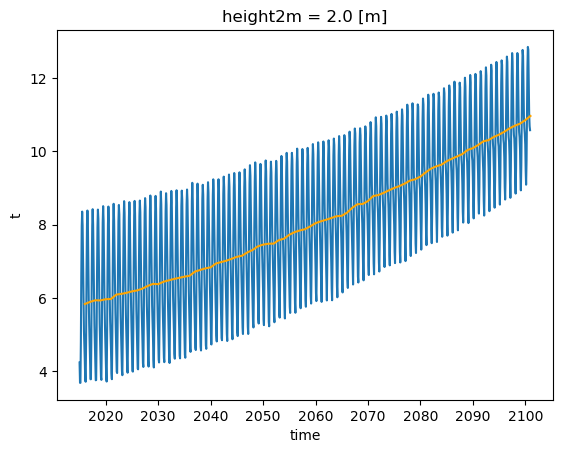

In [16]:
fig, axes = plt.subplots()

a.plot.line(x="time", ax=axes)
a.resample(time="YE").mean().plot.line(x="time", ax=axes, c="orange")

plt.savefig("t-unweighted-mean-ssp585.svg")